# Introduction à pytorch

In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import grad
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
from typing import Callable
from warnings import warn

## I) Les tenseurs

L'outil central de la librairie et la classe torch.Tensor qui permet de faire des calculs vectorizés et être indéxé à la manière d'une array numpy.
C'est un bloc contigue de mémoire qui contient des données typées, et est découpé en plusieurs dimensions. En plus du type de données, on peut définir si le tenseur requiert la propagation du gradient, et l'appareil sur lequel les données sont stockées et où les opérations seront effectuées ("cpu" ou "cuda:i").

In [2]:
t = torch.tensor([[1, 5], [3, 2]], dtype=torch.float32, requires_grad=False, device="cpu")  # la fonction "torch.tensor" permet de créer un tenseur de manière analogue à "np.array"
print(repr(t))

tensor([[1., 5.],
        [3., 2.]])


In [3]:
2*t - t**0.5 + 2  # Les opérations usuelles en numpy sont disponibles

tensor([[3.0000, 9.7639],
        [6.2679, 4.5858]])

In [4]:
(t.shape, t.dtype, t.requires_grad, t.device)  # les attributs usuels des array numpy sont nommées de manière identiques

(torch.Size([2, 2]), torch.float32, False, device(type='cpu'))

In [5]:
t[1, 1], t[:, 1], t[..., 0], t[0], t[:, :1]  # Les syntaxes d'indentation sont identiques à celles de numpy

(tensor(2.),
 tensor([5., 2.]),
 tensor([1., 3.]),
 tensor([1., 5.]),
 tensor([[1.],
         [3.]]))

Toutes les opérations usuelles de la librairie numpy existent dans pytorch (ou presque). Si le tenseur est sur un GPU, le calcul sera effectué de manière parallélisée sur GPU, ce qui peut très largement accélérer la vitesse d'execution pour des tenseurs de grande taille.

In [6]:
t.min(), t.mean(dim=1), t.max(), t.std(dim=0)  # les méthodes usuelles des array numpy sont nommées de manière identiques. Le kwargs "ax" est renommé "dim".

(tensor(1.), tensor([3.0000, 2.5000]), tensor(5.), tensor([1.4142, 2.1213]))

In [7]:
t @ -t  # Les opérateur aux sens spécifiques en numpy sont aussi implémentés. Ici équivalent à "torch.matmul(t, -t)".

tensor([[-16., -15.],
        [ -9., -19.]])

In [8]:
torch.exp(-t**2 + 2)  # les fonctions mathématiques courantes sont disponibles dans le namespace "torch"

tensor([[2.7183e+00, 1.0262e-10],
        [9.1188e-04, 1.3534e-01]])

In [9]:
F.elu(-t)  # Les fonctions liées à des opérations propres aux réseaux de neurones (loss, convolutions, activation, ...) se trouvent dans le namespace "torch.nn.functional"

tensor([[-0.6321, -0.9933],
        [-0.9502, -0.8647]])

In [10]:
torch.linalg.inv(t)  # Les fonctions d'algèbre linéaires de numpy sont implémentées dans le namespace "torch.linalg". Ici une opération d'inversion matricielle (dont on peut obtenir le gradient !)

tensor([[-0.1538,  0.3846],
        [ 0.2308, -0.0769]])

In [11]:
torch.rand((1,)), torch.randint(0, 3, (1,)), torch.normal(0., 1., (1,))  # Les fonctions de génération de nombres aléatoires ne sont pas (contrairement à numpy) dans le namespace torch.random !

(tensor([0.1024]), tensor([2]), tensor([0.9197]))

Tout comme les arrays numpy, on peut réorganiser la taille des dimensions (sans que la taille totale du tenseur ne change) ou l'ordre des dimensions

In [12]:
t = torch.arange(2*3*3, dtype=torch.long).reshape(3, 2, 3)
print(repr(t))

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])


In [13]:
t.transpose(1, 2)  # inverse l'ordre des dimensions 1 et 2

tensor([[[ 0,  3],
         [ 1,  4],
         [ 2,  5]],

        [[ 6,  9],
         [ 7, 10],
         [ 8, 11]],

        [[12, 15],
         [13, 16],
         [14, 17]]])

In [14]:
t.permute(1, 0, 2)  # permute l'ordre de toutes les dimensions dans l'ordre spécifié

tensor([[[ 0,  1,  2],
         [ 6,  7,  8],
         [12, 13, 14]],

        [[ 3,  4,  5],
         [ 9, 10, 11],
         [15, 16, 17]]])

In [15]:
t.unsqueeze(0).shape  # la méthode "unsqueeze" permet de créer des dimensions vide

torch.Size([1, 3, 2, 3])

In [16]:
t.unsqueeze(0).squeeze(0).shape  # la méthode "squeeze" à l'inverse permet de retirer une dimension vide

torch.Size([3, 2, 3])

## II) création du graph de calcul

Lorsqu'un tenseur requiert la propagation du gradient, le graphe de calcul est créé dynamiquement, de manière transparente pour l'utilisateur, lorsqu'on effectue des opérations, le résultat renvoyé est un nouveau tenseur lié au précédent par une branche du graphe deu calcul. Pour cette raison, il ne faut jamais modifier manuellement le contenu des tenseurs à travers lesquels on compte propager le gradient.

In [17]:
t = torch.arange(4, dtype=torch.float32, requires_grad=True)
print(repr(t))

tensor([0., 1., 2., 3.], requires_grad=True)


In [18]:
r = torch.sum(t**2)  # notez la présence de la "grad_fn" (gradient function) qui a donné lieu au nouveau tenseur.
print(repr(r))

tensor(14., grad_fn=<SumBackward0>)


In [19]:
r.backward()  # la méthode "backward" permet de propager le gradient dans tous le graph
print(repr(t.grad))  # on retrouve la solution analytique de la dérivée de la somme des carrés (y = 2*x), évaluées en [0, 1, 2, 3].

tensor([0., 2., 4., 6.])


In [20]:
# Une fois le gradient propagé, les résultats intermédiaires du graph de calcul sont supprimés pour libérer de la mémoire.
# On ne peut pas appeler backward une deuxième fois
try:
    r.backward()
except Exception as e:
    print(str(e))

Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


In [21]:
# On remarque alors que pytorch "accumule" les gradients au lieux d'écrire la nouvelle valuer par dessus l'ancienne.
r = torch.sum(t**2)
r.backward()
print(repr(t.grad))


tensor([ 0.,  4.,  8., 12.])


In [22]:
# Utiliser un contexte "torch.no_grad()" permet de ne pas construire le graph de calcul, et donc d'économiser la mémoire, et d'accélérer le calcul
t = torch.arange(4, dtype=torch.float32, requires_grad=True)
with torch.no_grad():
    r = torch.sum(t**2)
print(r.requires_grad)

False


## III) Les Modules pytorch

Dans pytorch une brique de modèle (une couche d'un modèle feed forward, ...) comme un modèle entier dérivent de la classe Module.
Les classes filles doivent implémenter la fonction "forward" qui correspond à la passe avant de la couche/du modèle (aka: l'opération effectuée)

In [23]:
lin = torch.nn.Linear(2, 3)  # certaines couches courrament utilisées sont déjà implémentées

In [24]:
help(lin)  # La couche linéaire (y = x@A.T + b) attend en entrée un tenseur de shape (n_observations, features_in) et renvoit un tenseur de shape (n_observations, features_out)

Help on Linear in module torch.nn.modules.linear object:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies a linear transformation to the incoming data: :math:`y = xA^T + b`
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(*, H_{in})` where :math:`*` means any number of
 |        dimensions including none and :math:`H_{in} = \text{in\_features}`.
 |      - Output: :math:`(*, H_{out})` where all but the last dimension
 |        are the same shape as the input and :mat

In [25]:
r = lin(torch.rand(10, 2))  # on peut appliquer l'opération correspondante en utilisant l'opérateur __call__
print(repr(r.shape))

torch.Size([10, 3])


In [26]:
list(lin.parameters())  # on peut obtenir un itérable des paramètres d'un module ave cla méthode "parameters"

[Parameter containing:
 tensor([[ 0.0406,  0.2595],
         [ 0.2693,  0.5511],
         [ 0.5593, -0.5775]], requires_grad=True),
 Parameter containing:
 tensor([-0.2776, -0.2002,  0.0033], requires_grad=True)]

In [27]:
class Layer(torch.nn.Module):
    """
    Un objet 'Layer' est une couche cachée d'un réseau feed forward
    """

    def __init__(self, in_features: int, out_features: int, activation: Callable, dropout: float, with_batch_norm: bool):
        """
        Parameters
        ----------
        in_features : int
            number of features in input tensors
        out_features : int
            number of features in output
        activation : Callable
            activation function applied after linear projection and batch normalization
        dropout : float
            dropout probability for gidden layers
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        super().__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.with_batch_norm = with_batch_norm
        self.batch_norm = torch.nn.BatchNorm1d(out_features)
        self.activation = activation
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of shape (N, H_in)
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        X = self.linear(X)
        if self.with_batch_norm:
            X = self.batch_norm(X)
        X = self.activation(X)
        X = self.dropout(X)
        return X

In [28]:
class FeedForwardRegressor(torch.nn.Module):
    """
    Un objet 'FeedForwardRegressor' est un modèle feed forward pour la régression
    """

    def __init__(self, in_features: int, hidden_features: list[int], activation: Callable = F.relu, dropout: float = 0., with_batch_norm: bool = True):
        super().__init__()
        self.hidden_layers = torch.nn.ModuleList()
        for out_features in hidden_features:
            self.hidden_layers.append(Layer(in_features, out_features, activation, dropout, with_batch_norm))
            in_features = out_features
        self.output_projection = torch.nn.Linear(out_features, 1)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of shape (N, H_in)
        
        Returns
        -------
        torch.Tensor :
            tensor of shape (N, H_out)
        """
        for layer in self.hidden_layers:
            X = layer(X)
        return self.output_projection(X)

In [29]:
ffr = FeedForwardRegressor(2, [10, 10, 10])
ffr(torch.rand(10, 2))

tensor([[-0.2524],
        [-0.0104],
        [ 0.0663],
        [ 0.4769],
        [-0.0944],
        [-0.1208],
        [-0.4339],
        [-0.0167],
        [ 0.1851],
        [ 0.1980]], grad_fn=<AddmmBackward0>)

In [30]:
list(ffr.children())  # On peut récupérer un itérable sur les sous modules avec la méthode "children"

[ModuleList(
   (0): Layer(
     (linear): Linear(in_features=2, out_features=10, bias=True)
     (batch_norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (1): Layer(
     (linear): Linear(in_features=10, out_features=10, bias=True)
     (batch_norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (2): Layer(
     (linear): Linear(in_features=10, out_features=10, bias=True)
     (batch_norm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (dropout): Dropout(p=0.0, inplace=False)
   )
 ),
 Linear(in_features=10, out_features=1, bias=True)]

In [31]:
len(list(ffr.parameters()))  # La méthode "parameter" renvoit aussi les groupes de paramètres des sous modules

14

In [32]:
# Certains Modules ne doivent pas avoir le même comportement lors de l'entraînement et de l'évaluation.
# Un flag permet de déterminer si le module est en mode entraînement ou évaluation
dropout = torch.nn.Dropout(p=0.5)
dropout.training

True

In [33]:
# on peut passer un module (et ses sous modules recursivement) en mode entraînement avec la méthode "train"
dropout.train()
dropout(torch.rand(3, 3))

tensor([[1.5342, 0.0000, 1.3908],
        [1.4722, 0.2964, 0.0000],
        [0.0000, 1.3672, 0.0000]])

In [34]:
# on peut passer un module (et ses sous modules recursivement) en mode entraînement avec la méthode "eval"
dropout.eval()
dropout(torch.rand(3, 3))

tensor([[0.4503, 0.8801, 0.9003],
        [0.2608, 0.1178, 0.6471],
        [0.0856, 0.7816, 0.7694]])

## IV) La boucle d'entraînement

In [35]:
def y(x: torch.Tensor) -> torch.Tensor:
    return x**2 + torch.normal(0., 0.1, x.shape)

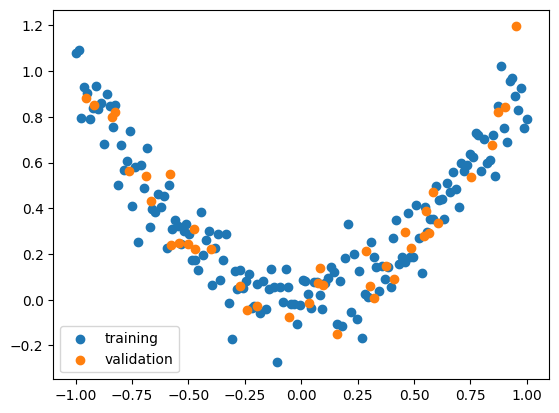

In [36]:
x_train = torch.linspace(-1., 1., 160).unsqueeze(1)
y_train = y(x_train)
x_val = torch.rand((40, 1)) * 2 - 1
y_val = y(x_val)
plt.scatter(x_train.reshape(-1).tolist(), y_train.reshape(-1).tolist(), label="training")
plt.scatter(x_val.reshape(-1).tolist(), y_val.reshape(-1).tolist(), label="validation")
plt.legend()

In [37]:
def loss_function(y_pred: torch.Tensor, y_target: torch.Tensor) -> torch.Tensor:
    """
    returns the mean squared error loss

    Parameters
    ----------
    y_pred : torch.Tensor
        tensor of shape (N,)
    y_target : torch.Tensor
        tensor of shape (N,)
    
    Returns
    -------
    torch.Tensor :
        scalar tensor
    """
    return F.mse_loss(y_pred, y_target)

In [38]:
def train_loop(model: torch.nn.Module, optimizer: torch.optim.Optimizer, train_data: tuple[torch.Tensor], val_data: tuple[torch.Tensor], loss_function: Callable, n_steps: int = 100, patience: int = 10, keep_best: bool = True):
    """
    performs the training for a given number of iterations
    """
    x_train, y_train = train_data
    x_val, y_val = val_data
    best_metric = float("inf")
    best_step = 0
    checkpoint = deepcopy(model.state_dict())
    try:
        for step in range(n_steps):
            # setting the gradient to zero to avoid gradient accumulation
            optimizer.zero_grad()
            # training
            model.train()
            loss = loss_function(model(x_train), y_train)
            loss.backward()
            # validation
            model.eval()
            with torch.no_grad():
                metric = loss_function(model(x_val), y_val).item()
            if metric < best_metric:
                best_metric = metric
                best_step = step
                if keep_best:
                    checkpoint = deepcopy(model.state_dict())
            elif step - best_step == patience:
                print("early stopping")
                break
            # printing progress
            print(f"Step {step}: loss = {loss.item():.3g}, metric = {metric:.3g}", flush=True)
            # step of the optimizer
            optimizer.step()
    except KeyboardInterrupt:
        print("interupted by user")
    if keep_best:
        model.load_state_dict(checkpoint)

In [39]:
# Le namespace "optim" contient les différents algorithmes d'optimisation
ffr = FeedForwardRegressor(1, [30, 30])
optimizer = torch.optim.Adam(ffr.parameters(), lr=1.0E-3)
train_loop(ffr, optimizer, (x_train, y_train), (x_val, y_val), F.mse_loss, n_steps=200, patience=100)

Step 0: loss = 0.217, metric = 0.149
Step 1: loss = 0.16, metric = 0.148
Step 2: loss = 0.111, metric = 0.147
Step 3: loss = 0.0752, metric = 0.145
Step 4: loss = 0.0527, metric = 0.144
Step 5: loss = 0.0404, metric = 0.143
Step 6: loss = 0.0341, metric = 0.142
Step 7: loss = 0.0312, metric = 0.14
Step 8: loss = 0.0301, metric = 0.137
Step 9: loss = 0.0296, metric = 0.134
Step 10: loss = 0.0291, metric = 0.131
Step 11: loss = 0.0282, metric = 0.129
Step 12: loss = 0.0268, metric = 0.126
Step 13: loss = 0.0251, metric = 0.124
Step 14: loss = 0.023, metric = 0.122
Step 15: loss = 0.0208, metric = 0.121
Step 16: loss = 0.0186, metric = 0.12
Step 17: loss = 0.0166, metric = 0.119
Step 18: loss = 0.015, metric = 0.119
Step 19: loss = 0.0137, metric = 0.118
Step 20: loss = 0.0129, metric = 0.118
Step 21: loss = 0.0126, metric = 0.117
Step 22: loss = 0.0127, metric = 0.116
Step 23: loss = 0.013, metric = 0.115
Step 24: loss = 0.0133, metric = 0.113
Step 25: loss = 0.0136, metric = 0.109
Step 

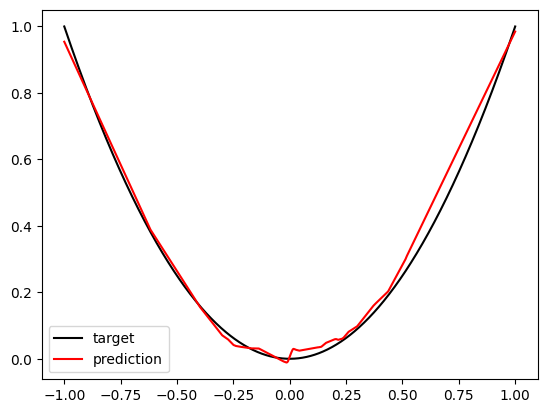

In [40]:
x_test = torch.linspace(-1, 1, 1000)
y_target = x_test**2
y_pred = ffr(x_test.unsqueeze(-1)).squeeze(-1)
plt.plot(x_test.tolist(), y_target.tolist(), color="k", label="target")
plt.plot(x_test.tolist(), y_pred.tolist(), color="r", label="prediction")
plt.legend()

## V) Une loss pour la classification

In [41]:
def y(x: torch.Tensor) -> torch.Tensor:
    """
    returns the binary classification of the given (x1, x2) points

    Parameters
    ----------
    x : torch.Tensor
        tensor of shape (n, 2) of floats in [-1, 1]

    Returns
    -------
    torch.Tensor
        tensor of shape (n, 1) of type long, of values in {0, 1}
    """
    L = 0.8
    return (((x[:, 0] + x[:, 1]) % L) > L/2).float().unsqueeze(-1)


def generate_data(n: int) -> tuple[torch.Tensor]:
    """
    generate an (x, y) tuple of tensors of n random observations
    """
    x = torch.rand(n, 2) * 2 - 1
    y_ = y(x)
    return x, torch.where(torch.rand(n, 1) < 0.05, 1-y_, y_)

In [42]:
x_train, y_train = generate_data(800)
x_val, y_val = generate_data(200)

In [43]:
y_train.shape

torch.Size([800, 1])

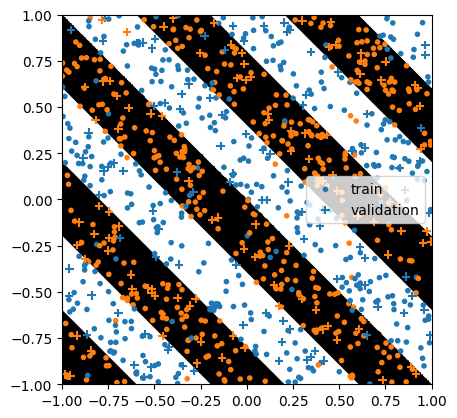

In [44]:
image = y(torch.stack(torch.meshgrid([torch.linspace(-1., 1., 500)]*2, indexing="ij"), dim=-1).reshape(-1, 2)).reshape(500, 500)
plt.imshow(image, extent=(-1, 1, -1, 1), origin="lower", cmap="Greys", vmin=0, vmax=1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=[f"C{c.item()}" for c in y_train.int()], marker=".", label="train")
plt.scatter(x_val[:, 0], x_val[:, 1], c=[f"C{c.item()}" for c in y_val.int()], marker="+", label="validation")
plt.legend()

In [45]:
class FeedForwardClassifier(torch.nn.Module):
    """
    Un objet 'FeedForwardRegressor' est un modèle feed forward pour la classification binaire
    """

    def __init__(self, in_features: int, hidden_layers: list[int], activation: Callable = F.relu, dropout: float = 0., with_batch_norm: bool = True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for out_features in hidden_layers:
            self.layers.append(Layer(in_features, out_features, activation, dropout, with_batch_norm))
            in_features = out_features
        self.output_projection = torch.nn.Linear(out_features, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            X = layer(X)
        return torch.sigmoid(self.output_projection(X))

In [46]:
ffc = FeedForwardClassifier(2, [30, 30, 30, 30])
optimizer = torch.optim.Adam(ffc.parameters(), lr=1.0E-3)
train_loop(ffc, optimizer, (x_train, y_train), (x_val, y_val), F.binary_cross_entropy, n_steps=1000, patience=100)

Step 0: loss = 0.716, metric = 0.695
Step 1: loss = 0.7, metric = 0.695
Step 2: loss = 0.688, metric = 0.695
Step 3: loss = 0.678, metric = 0.696
Step 4: loss = 0.671, metric = 0.696
Step 5: loss = 0.664, metric = 0.696
Step 6: loss = 0.658, metric = 0.696
Step 7: loss = 0.652, metric = 0.696
Step 8: loss = 0.647, metric = 0.696
Step 9: loss = 0.642, metric = 0.696
Step 10: loss = 0.637, metric = 0.696
Step 11: loss = 0.632, metric = 0.696
Step 12: loss = 0.628, metric = 0.696
Step 13: loss = 0.625, metric = 0.696
Step 14: loss = 0.621, metric = 0.696
Step 15: loss = 0.617, metric = 0.697
Step 16: loss = 0.613, metric = 0.697
Step 17: loss = 0.609, metric = 0.697
Step 18: loss = 0.605, metric = 0.698
Step 19: loss = 0.601, metric = 0.698
Step 20: loss = 0.596, metric = 0.698
Step 21: loss = 0.592, metric = 0.699
Step 22: loss = 0.588, metric = 0.699
Step 23: loss = 0.584, metric = 0.699
Step 24: loss = 0.579, metric = 0.698
Step 25: loss = 0.575, metric = 0.697
Step 26: loss = 0.57, me

In [47]:
with torch.no_grad():
    image = ffc(torch.stack(torch.meshgrid([torch.linspace(-1., 1., 500)]*2, indexing="ij"), dim=-1).reshape(-1, 2)).reshape(500, 500)

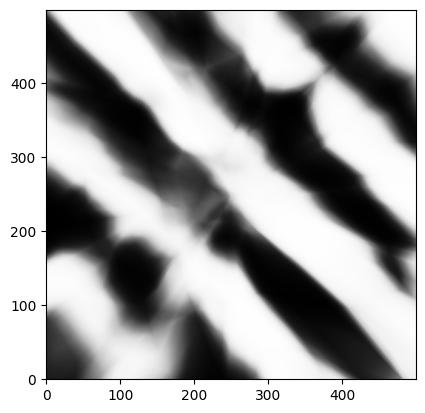

In [48]:
plt.imshow(image.numpy(), origin="lower", cmap="Greys")

## VI) Exercice



In [66]:
df = pd.read_csv("../datasets/train.csv")
df_train = df.sample(frac=0.8)
df_val = df.drop(df_train.index)
df_test = pd.read_csv("../datasets/test.csv")
df_eval = pd.read_csv("../datasets/eval_public.csv")
df_eval = pd.read_csv("../datasets/eval.csv")

all_inputs = ['type_contrat', 'formation_selective',
              'concour', 'nombre_candidats', 'taux_femmes',
              'taux_boursiers', 'taux_meme_academie', 'taux_meme_etablissement',
              'taux_bac_technologique', 'taux_bac_pro', 'taux_mention_assez_bien',
              'taux_mention_bien', 'taux_mention_tres_bien',
              'taux_mention_tres_bien_felicitations']

In [67]:
class GaussianRegressor(torch.nn.Module):
    """
    Un régresseur gaussien doit renvoyer un tuple de tenseurs (mu, sigma)
    avec mu la moyenne prédite pour chaque observation,
    et sigma l'écart type de l'erreur pour chaque observation.
    """

    def __init__(self, in_features: int, hidden_features: list[int], activation: Callable = F.relu, dropout: float = 0., with_batch_norm: bool = True):
        super().__init__()
        self.hidden_layers = torch.nn.ModuleList()
        for out_features in hidden_features:
            self.hidden_layers.append(Layer(in_features, out_features, activation, dropout, with_batch_norm=with_batch_norm))
            in_features = out_features
        self.output_projection = torch.nn.Linear(in_features, 2)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of shape (N, 14)
        
        Returns
        -------
        tuple of torch.Tensor :
            returns a tuple of (mu, sigma) tensors of shape (N,)
        """
        for layer in self.hidden_layers:
            X = layer(X)
        X = self.output_projection(X)
        mu, sigma = X[..., 0], X[..., 1]
        return torch.sigmoid(mu), torch.exp(sigma)

In [88]:
def dataframe_to_x(df: pd.DataFrame, inputs: list[str]) -> torch.Tensor:
    """
    converts a dataframe to a tensor of inputs 'x'

    Parameters
    ----------
    df : pd.DataFrame
        data to convert to input tensor
    inputs : list of str
        list of columns to use (in order)
    
    Returns
    -------
    torch.Tensor :
        tensor of floats of shape (N, C)
    """
    df = df[inputs].copy()
    if "nombre_candidats" in df.columns:
        df["nombre_candidats"] = df["nombre_candidats"]/1413
    if "type_contrat" in df.columns:
        df["type_contrat"] = [0 if tc.startswith("Public") else 1 for tc in df["type_contrat"]]
    return torch.tensor(df.astype(float).to_numpy(), dtype=torch.float32)


def dataframe_to_y(df: pd.DataFrame) -> torch.Tensor:
    """
    converts a dataframe to a tensor of target 'y'

    Parameters
    ----------
    df : pd.DataFrame
        data to convert to target tensor

    Returns
    -------
    torch.Tensor :
        tensor of floats of shape (N, C)
    """
    return torch.tensor(df['taux_admission'].astype(float).to_numpy(), dtype=torch.float32)


def predict(model: torch.nn.Module, df: pd.DataFrame, inputs: list[str]) -> torch.Tensor:
    """
    performs a prediction of the model in evaluation mode
    and returns the (mu, sigma) tuple
    """
    x = dataframe_to_x(df, inputs=inputs)
    model.eval()
    with torch.no_grad():
        mu, sigma = model(x)
    return pd.DataFrame.from_dict({"mu": mu.tolist(), "sigma": sigma.tolist()})


def mean_negative_log_likelyhood(y_pred: tuple[torch.Tensor], y_target: torch.Tensor) -> torch.Tensor:
    """
    returns the mean negative log likelyhood of the model, to be used as a loss
    """
    mu, sigma = y_pred
    if (sigma <= 0).any():
        warn("All values of sigma are expected to be strictly positives but found some negative or null")
    log_likelyhood = -0.5*(((y_target-mu)/sigma)**2) - torch.log(sigma * (2*torch.pi)**0.5)
    return torch.mean(-log_likelyhood)


def note(prediction: pd.DataFrame, df_test: pd.DataFrame) -> float:
    """
    Grades the student on the evaluation set (between 0. and 20.)
    """
    mu, sigma = torch.tensor(prediction.mu, dtype=torch.float), torch.tensor(prediction.sigma, dtype=torch.float)
    with torch.no_grad():
        mnll = mean_negative_log_likelyhood((mu, sigma), dataframe_to_y(df_test))
    frac = torch.sigmoid(-mnll*2).item()
    return round(frac * 20, 1)


def visualize(model: torch.nn.Module, df_test: pd.DataFrame, inputs: list[str]):
    """
    Plots the performance of the model
    """
    y = dataframe_to_y(df_test)
    res = predict(model, df_test, inputs)
    plt.axline((0., 0.), slope=1, color="k", zorder=0)
    h = plt.scatter(res.mu, y, c=res.sigma, cmap="inferno", s=10, zorder=1)
    plt.colorbar(h)
    plt.xlabel("target")
    plt.ylabel("predicted")

In [118]:
inputs =  all_inputs
train = (dataframe_to_x(df_train, inputs), dataframe_to_y(df_train))
val = (dataframe_to_x(df_val, inputs), dataframe_to_y(df_val))
gr = GaussianRegressor(len(inputs), [30, 30], activation=F.leaky_relu, dropout=0.)
optimizer = torch.optim.Adam(gr.parameters(), lr=1.0E-3)
train_loop(gr, optimizer, train, val, mean_negative_log_likelyhood, n_steps=1000, patience=100)

Step 0: loss = 0.793, metric = 0.914
Step 1: loss = 0.772, metric = 0.916
Step 2: loss = 0.753, metric = 0.916
Step 3: loss = 0.734, metric = 0.914
Step 4: loss = 0.715, metric = 0.911
Step 5: loss = 0.696, metric = 0.906
Step 6: loss = 0.678, metric = 0.899
Step 7: loss = 0.66, metric = 0.89
Step 8: loss = 0.642, metric = 0.881
Step 9: loss = 0.624, metric = 0.87
Step 10: loss = 0.607, metric = 0.859
Step 11: loss = 0.59, metric = 0.847
Step 12: loss = 0.573, metric = 0.835
Step 13: loss = 0.556, metric = 0.822
Step 14: loss = 0.539, metric = 0.808
Step 15: loss = 0.523, metric = 0.794
Step 16: loss = 0.506, metric = 0.78
Step 17: loss = 0.49, metric = 0.764
Step 18: loss = 0.474, metric = 0.748
Step 19: loss = 0.459, metric = 0.731
Step 20: loss = 0.443, metric = 0.714
Step 21: loss = 0.427, metric = 0.696
Step 22: loss = 0.412, metric = 0.677
Step 23: loss = 0.397, metric = 0.657
Step 24: loss = 0.382, metric = 0.636
Step 25: loss = 0.367, metric = 0.615
Step 26: loss = 0.352, metri

In [119]:
note(predict(gr, df_test, inputs), df_test)

14.7

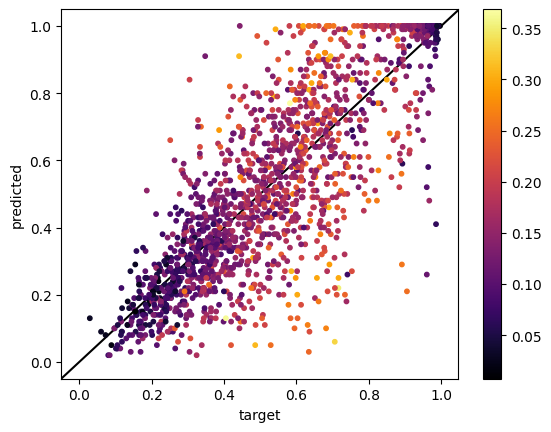

In [120]:
visualize(gr, df_test, inputs)

In [121]:
predict(gr, df_eval, inputs).to_csv("prediction.csv", index=False)

In [122]:
note(predict(gr, df_eval, inputs), df_eval)

12.6